# Analysis of pilot MERFISH data

Brains and pituitary glands were collected separately from 6-week-old B6/AJ F1 mice and fresh-frozen in OCT. The data consists of 3 hypothalamus coronal sections from 3 individuals, 1 complete pituitary coronal section, and 2 incomplete pituitary coronal sections. Processed using v1.0 MERFISH chemistry (sample prep kit cat. #10400012, imaging kit cat. #10400005, slides cat. #10500001) and imaged on MERSCOPE Ultra instrument. Designed [300 gene panel](https://docs.google.com/spreadsheets/d/1JkyxyGoJ88RZw2jjLuQRELEANUxl-QASRcivJyJLXVk/edit?gid=0#gid=0) based on canonical marker genes, cluster markers from analysis of corresponding snRNA-seq data of the same region, and genotype-specific markers from our [analysis of diverse mouse strains](https://www.biorxiv.org/content/10.1101/2025.04.21.649844v1).

- R2: Hypothalamus (#897 female)
- R3: Pituitary (#897 female)
- R5: Incomplete pituitary (#895 male)
- R6: Hypothalamus (#895 male)
- R7: Hypothalamus (#891 male)
- R8: Incomplete pituitary (#893 male)

Following squidpy analysis tutorial [here](https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_vizgen.html).

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import squidpy as sq


/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


# Load Anndata

In [87]:
adata = sq.read.vizgen(
    path="pilot_data/region_R2/",
    counts_file="cell_by_gene.csv",
    meta_file="cell_metadata.csv",
    transformation_file="micron_to_mosaic_pixel_transform.csv",
)

adata.layers["counts"] = adata.X.copy()


In [88]:
sc.pp.calculate_qc_metrics(adata, percent_top=(50, 100, 200, 300), inplace=True)


In [89]:
adata

AnnData object with n_obs × n_vars = 40632 × 300
    obs: 'fov', 'volume', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_300_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'blank_genes', 'spatial'
    layers: 'counts'

In [90]:
vol = adata.obs["volume"]
median_volume = np.median(vol)
volume_filter = (vol >= 100) & (vol <= 3 * median_volume)
adata = adata[volume_filter].copy()

# Remove cells with total RNA in top/bottom 1%
total_counts = adata.obs['total_counts']
lower = np.percentile(total_counts, 1)
upper = np.percentile(total_counts, 99)
in_range = (total_counts >= lower) & (total_counts <= upper)
adata = adata[in_range].copy()


In [92]:
adata.obs['total_counts'].min()


12.0

In [85]:
adata.write_h5ad('region_R2_adata_filt.h5ad')

In [171]:
adata = sc.read_h5ad('region_R2_adata_filt_scrublet.h5ad')

In [172]:
adata

AnnData object with n_obs × n_vars = 39699 × 300
    obs: 'fov', 'volume', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_300_genes', 'doublet_score', 'predicted_doublet'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'scrublet', 'spatial'
    obsm: 'blank_genes', 'spatial'
    layers: 'counts'

# Normalize according to 

https://www.nature.com/articles/s41586-023-06808-9

In [173]:
from scipy import sparse
# normalize counts by volume
inv_volumes = 1 / adata.obs["volume"].values # scaling factor 
inv_vol_diag = sparse.diags(inv_volumes)
adata.layers["counts_volume_norm"] = inv_vol_diag @ adata.layers["counts"]

# scale
total_counts = np.array(adata.layers["counts_volume_norm"].sum(axis=1)).flatten()
scale_factor = 250 / np.mean(total_counts)

adata.layers["counts_volume_norm_scaled"] = adata.layers["counts_volume_norm"] * scale_factor

adata = adata[adata.obs["doublet_score"] <= 0.25].copy()


In [174]:
adata

AnnData object with n_obs × n_vars = 39526 × 300
    obs: 'fov', 'volume', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_300_genes', 'doublet_score', 'predicted_doublet'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'scrublet', 'spatial'
    obsm: 'blank_genes', 'spatial'
    layers: 'counts', 'counts_volume_norm', 'counts_volume_norm_scaled'

In [175]:
adata.obsm["blank_genes"].to_numpy().sum() / adata.var["total_counts"].sum() * 100


0.2337627811357379

In [176]:
adata.obs['region'] = 'R2'

/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` par

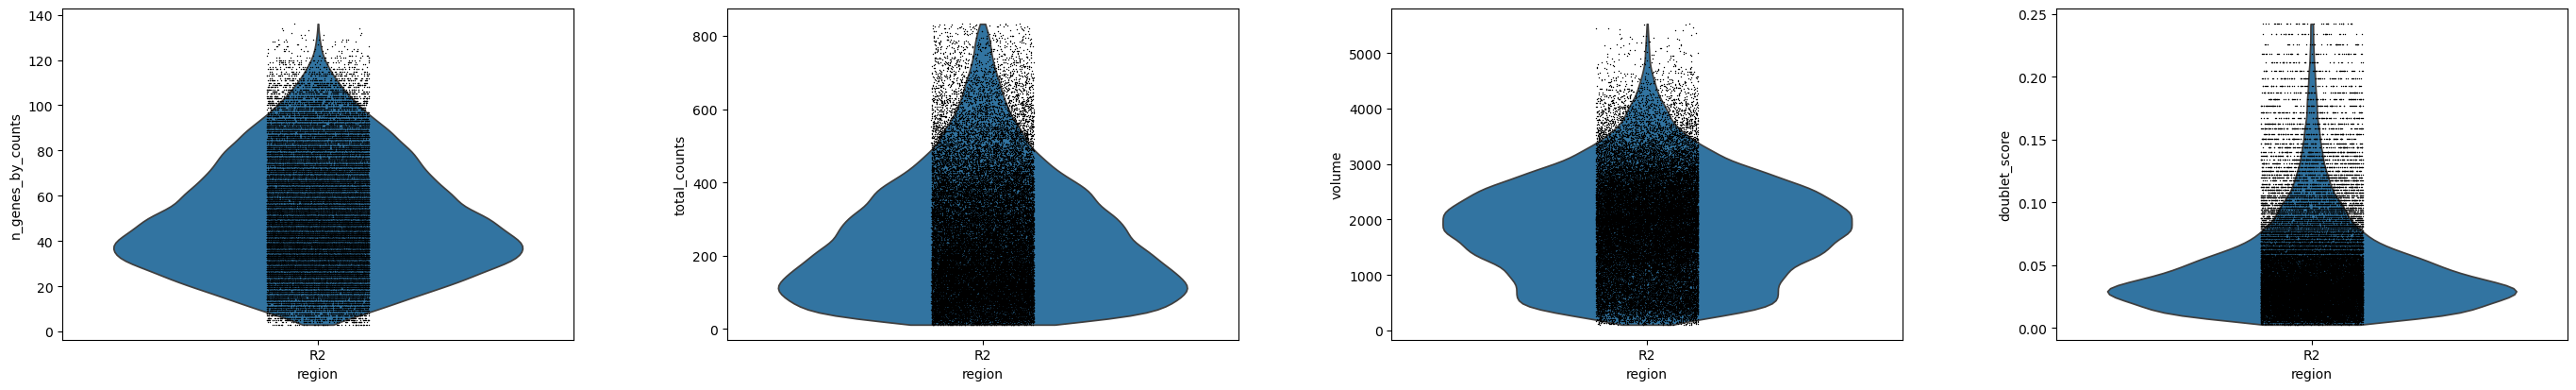

In [177]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "volume", "doublet_score"],
    groupby="region",
    multi_panel = True
)

In [178]:
adata.obs['volume'].median()

1847.6586116455449

# Normalized by volume  + scaled

In [179]:
adata.X = adata.layers['counts_volume_norm_scaled'].copy()

In [180]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=4000)
# sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


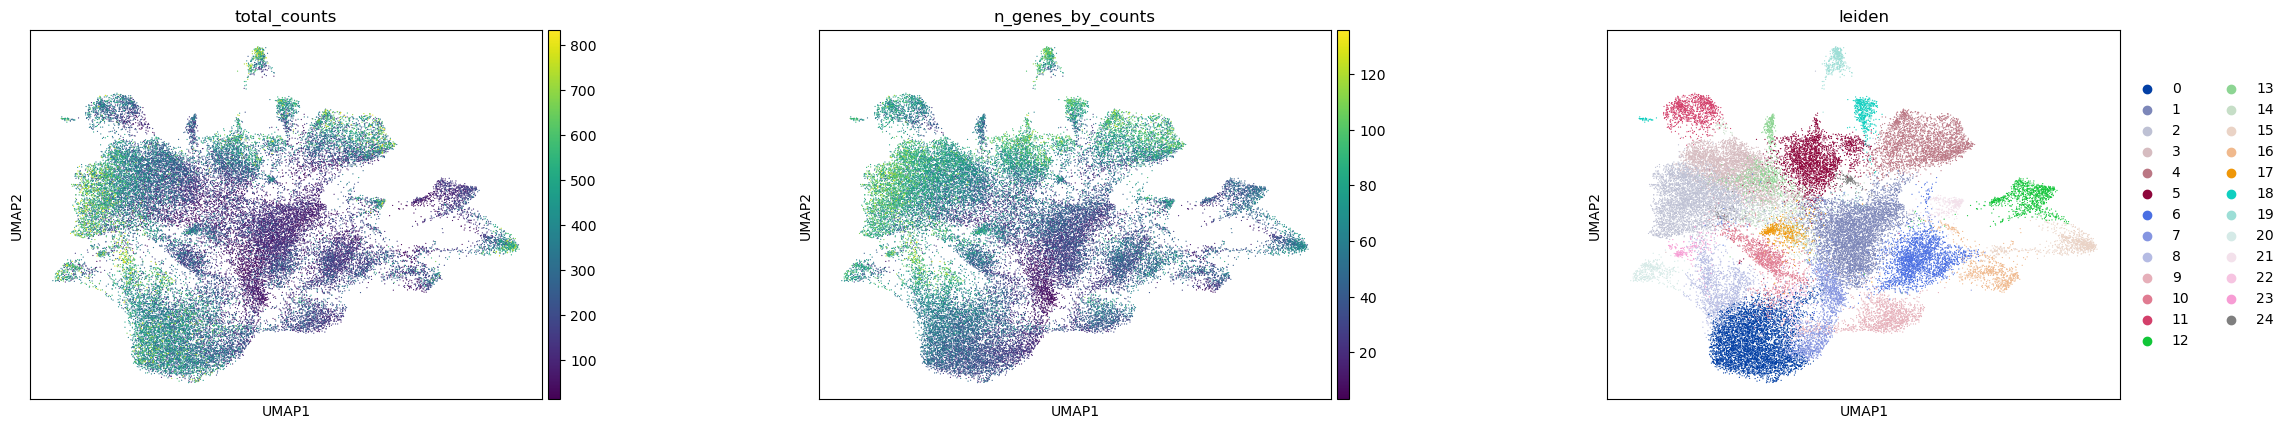

In [181]:
sc.pl.umap(
    adata,
    color=[
        "total_counts",
        "n_genes_by_counts",
        "leiden",
    ],
    wspace=0.4,
)

/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:179: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax

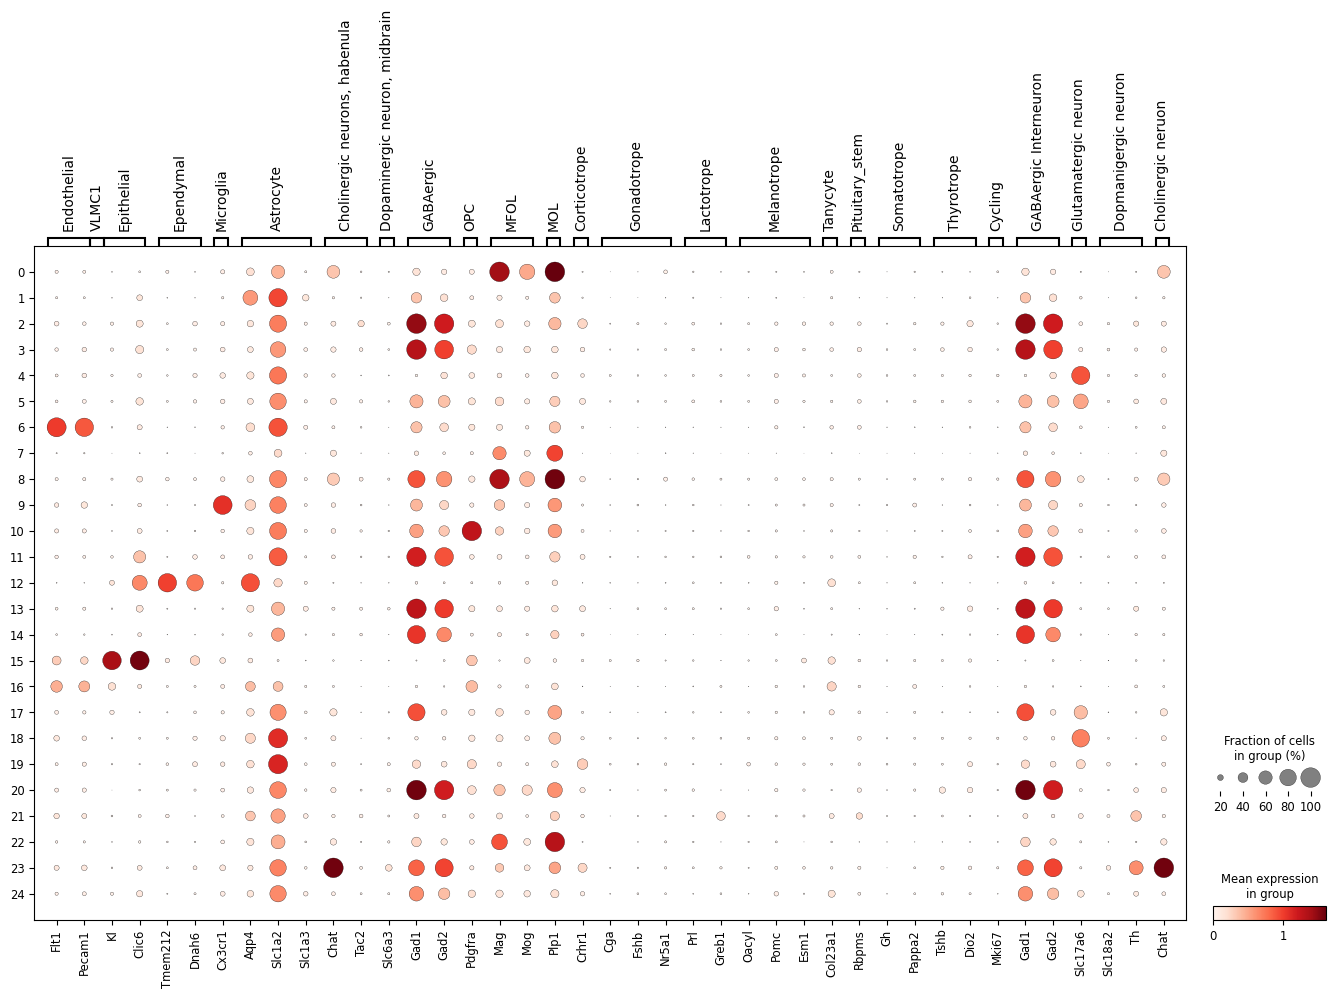

In [182]:
gene_list  = adata.var_names.tolist()
annotation_dict = {
    "Endothelial": ["Flt1","Pecam1"],
    "Pericyte": ["Vtn"],
    "Fibroblast": ["Bnc2","Fbxl7"],
    "VLMC1": ["Dcn"],
    "VLMC2": ['Egfr','Tbx15','Rspo3','Slc26a7'],
    "Epithelial":["Kl","Ttr","Clic6"], # http://mousebrain.org/celltypes/CHOR.html
    "Ependymal":["Tmem212","Dnah6"],
    "Hypendymal":['Spp2','Sspo'], # http://mousebrain.org/celltypes/HYPEN.html
    "Microglia": ["Cx3cr1"],
    "Astrocyte": ["Aqp4","Clu","Cpe","Gfap","Gja1","Slc1a2","Slc1a3"],
    "Excitatory neuron, thalamus": ["Synpo2","Prkcd","Ramp3","Ptpn3","Shox2"], #http://mousebrain.org/celltypes/DEGLU1.html
    "Cholinergic neurons, habenula": ['Chat','Lrrc55','Tac2','Nwd2'],
    "Dopaminergic neuron, midbrain": ["Slc6a3","En1"], # http://mousebrain.org/celltypes/MBDOP2.html
    "GABAergic": ["Gad1","Gad2"],
    "OPC": ["Pdgfra"],
    "COP": ["C1ql1"],
    "MFOL": ["Mag","Mog"],
    "MOL": ["Plp1"],
    "Corticotrope": ["Crhr1","Tbx19"],
    "Gonadotrope": ["Cga","Fshb","Nr5a1"],
    "Lactotrope": ["Prl","Greb1","Agtr1a"],
    "Melanotrope": ["Oacyl","Pomc","Esm1"],
    "Tanycyte": ['Col23a1','Rax','Lhx2','Prdx6','Ptn'],
    "Pituitary_stem": ["Rbpms","Cyp2f2","Sox2","Aldh1a2"],
    "Somatotrope": ["Gh","Pappa2"],
    "Thyrotrope": ["Tshb","Dio2"],
    "Cycling": ["Top2a","Mki67"],
    "GABAergic Interneuron":["Gad1", "Gad2"],
    "Glutamatergic neuron": ["Slc17a6"],
    "Dopmanigergic neuron": ["Slc18a2", "Th"],
    "Cholinergic neruon":["Chat"],
    "Neuron": ["Mir124a-1hg","Snap25"]
}
filtered_markers = {
    key: [v for v in vals if v in gene_list]
    for key, vals in annotation_dict.items()
}
keys_to_remove = ["Pericyte", "Fibroblast", 
                  "VLMC2","Hypendymal",
                  "Excitatory neuron, thalamus","COP","Neuron"]
for k in keys_to_remove:
    filtered_markers.pop(k, None)   # safely remove if present

sc.pl.dotplot(adata, 
              filtered_markers, 
              'leiden', 
              mean_only_expressed = False, 
              log=True, 
             )

# Default normalization

In [164]:
adata = sc.read_h5ad('region_R2_adata_filt_scrublet.h5ad')


In [165]:

adata = adata[adata.obs["doublet_score"] <= 0.25].copy()


In [166]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=4000)
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


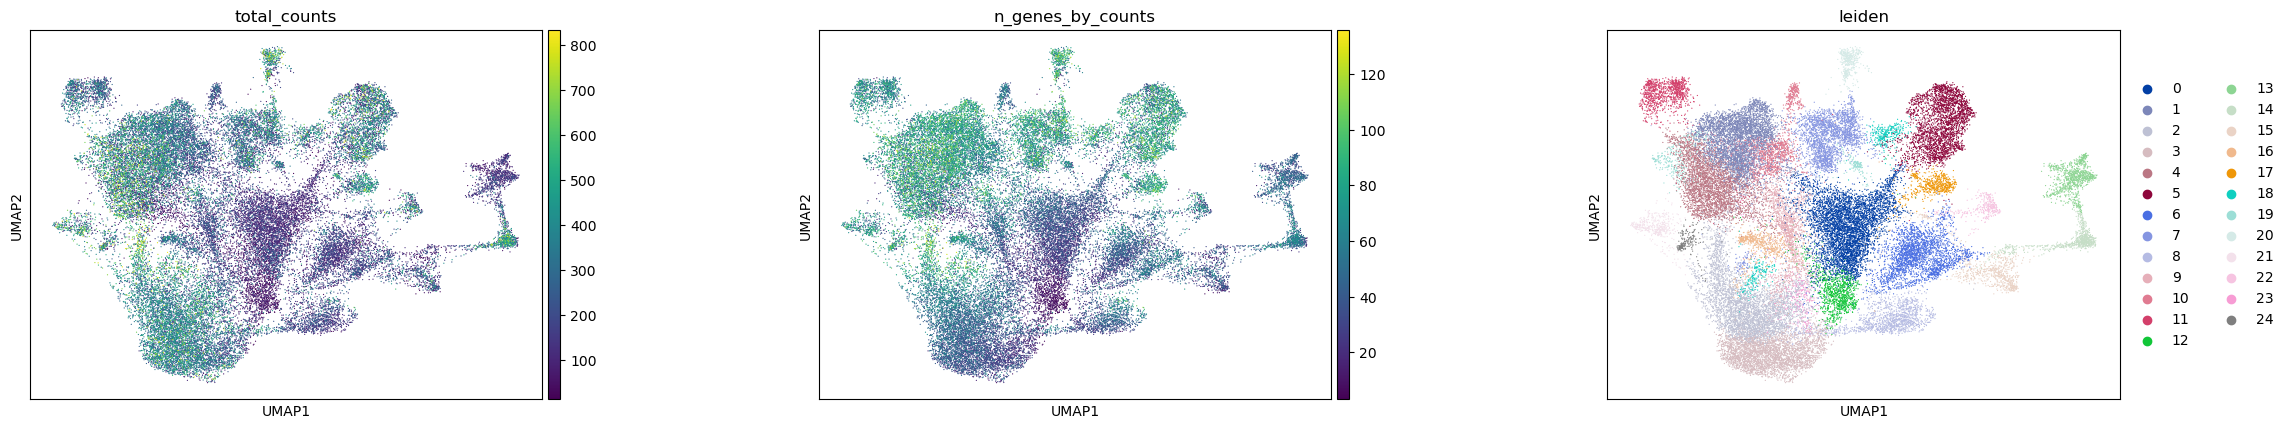

In [167]:
sc.pl.umap(
    adata,
    color=[
        "total_counts",
        "n_genes_by_counts",
        "leiden",
    ],
    wspace=0.4,
)

/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:179: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax

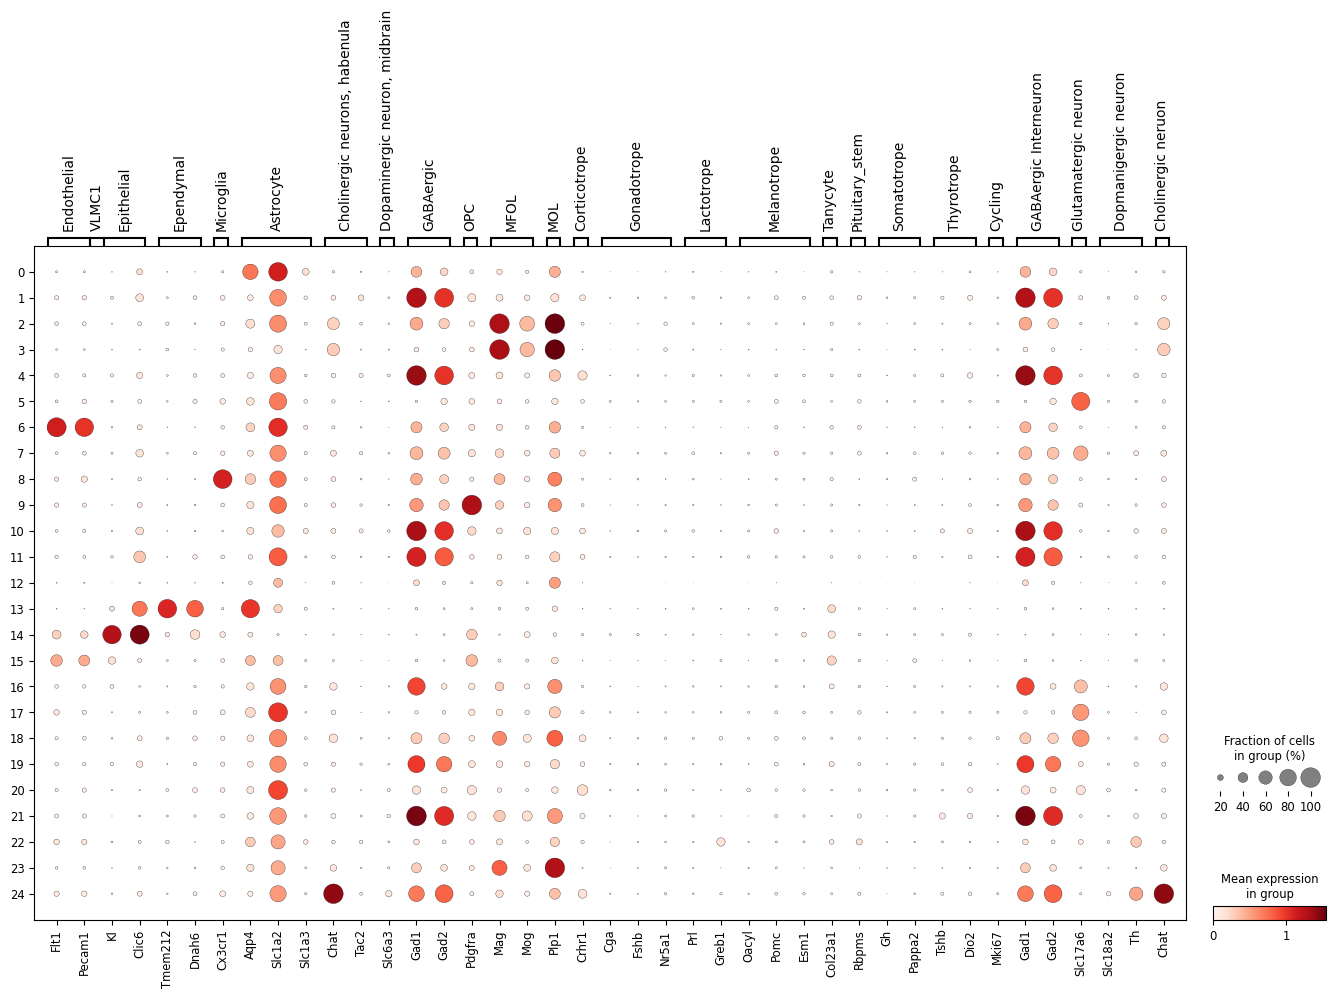

In [170]:
gene_list  = adata.var_names.tolist()
annotation_dict = {
    "Endothelial": ["Flt1","Pecam1"],
    "Pericyte": ["Vtn"],
    "Fibroblast": ["Bnc2","Fbxl7"],
    "VLMC1": ["Dcn"],
    "VLMC2": ['Egfr','Tbx15','Rspo3','Slc26a7'],
    "Epithelial":["Kl","Ttr","Clic6"], # http://mousebrain.org/celltypes/CHOR.html
    "Ependymal":["Tmem212","Dnah6"],
    "Hypendymal":['Spp2','Sspo'], # http://mousebrain.org/celltypes/HYPEN.html
    "Microglia": ["Cx3cr1"],
    "Astrocyte": ["Aqp4","Clu","Cpe","Gfap","Gja1","Slc1a2","Slc1a3"],
    "Excitatory neuron, thalamus": ["Synpo2","Prkcd","Ramp3","Ptpn3","Shox2"], #http://mousebrain.org/celltypes/DEGLU1.html
    "Cholinergic neurons, habenula": ['Chat','Lrrc55','Tac2','Nwd2'],
    "Dopaminergic neuron, midbrain": ["Slc6a3","En1"], # http://mousebrain.org/celltypes/MBDOP2.html
    "GABAergic": ["Gad1","Gad2"],
    "OPC": ["Pdgfra"],
    "COP": ["C1ql1"],
    "MFOL": ["Mag","Mog"],
    "MOL": ["Plp1"],
    "Corticotrope": ["Crhr1","Tbx19"],
    "Gonadotrope": ["Cga","Fshb","Nr5a1"],
    "Lactotrope": ["Prl","Greb1","Agtr1a"],
    "Melanotrope": ["Oacyl","Pomc","Esm1"],
    "Tanycyte": ['Col23a1','Rax','Lhx2','Prdx6','Ptn'],
    "Pituitary_stem": ["Rbpms","Cyp2f2","Sox2","Aldh1a2"],
    "Somatotrope": ["Gh","Pappa2"],
    "Thyrotrope": ["Tshb","Dio2"],
    "Cycling": ["Top2a","Mki67"],
    "GABAergic Interneuron":["Gad1", "Gad2"],
    "Glutamatergic neuron": ["Slc17a6"],
    "Dopmanigergic neuron": ["Slc18a2", "Th"],
    "Cholinergic neruon":["Chat"],
    "Neuron": ["Mir124a-1hg","Snap25"]
}
filtered_markers = {
    key: [v for v in vals if v in gene_list]
    for key, vals in annotation_dict.items()
}
keys_to_remove = ["Pericyte", "Fibroblast", 
                  "VLMC2","Hypendymal",
                  "Excitatory neuron, thalamus","COP","Neuron"]
for k in keys_to_remove:
    filtered_markers.pop(k, None)   # safely remove if present

sc.pl.dotplot(adata, 
              filtered_markers, 
              'leiden', 
              mean_only_expressed = False, 
              log=True, 
             )

/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


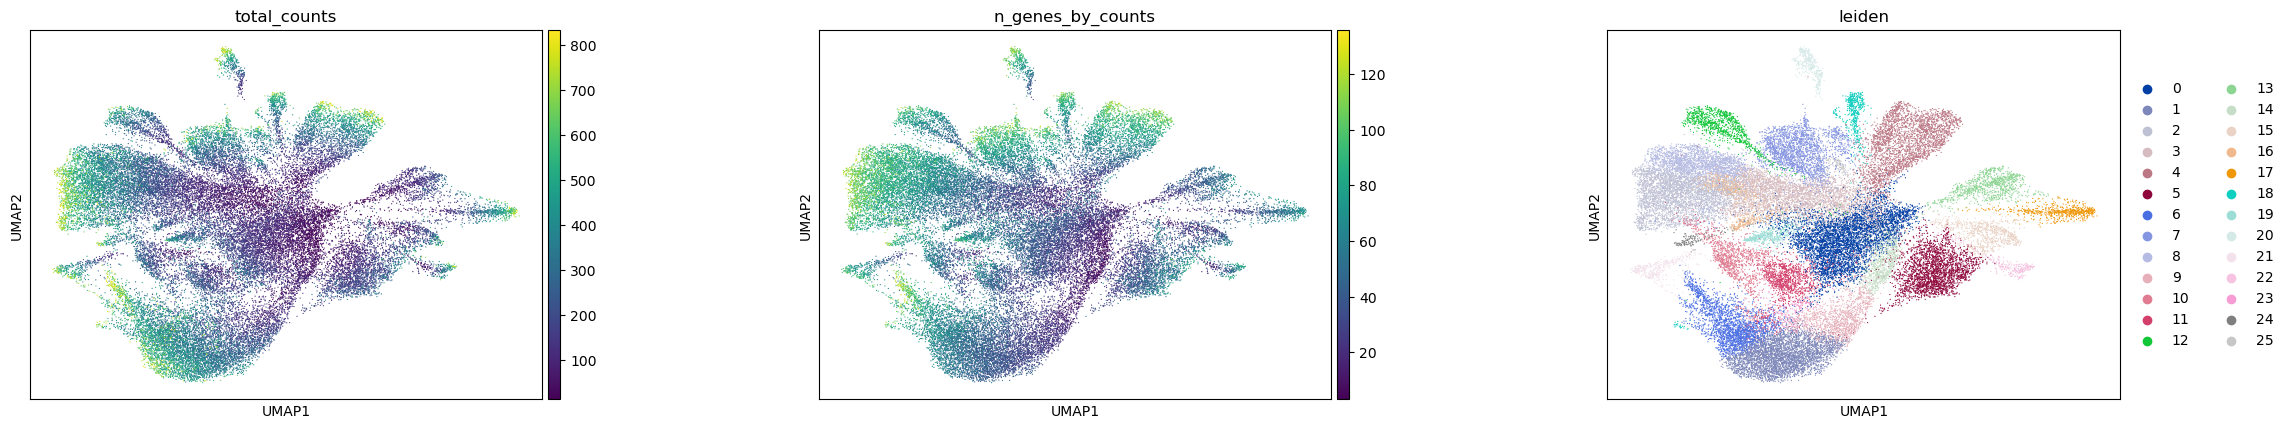

In [127]:
sc.pl.umap(
    adata,
    color=[
        "total_counts",
        "n_genes_by_counts",
        "leiden",
    ],
    wspace=0.4,
)

/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


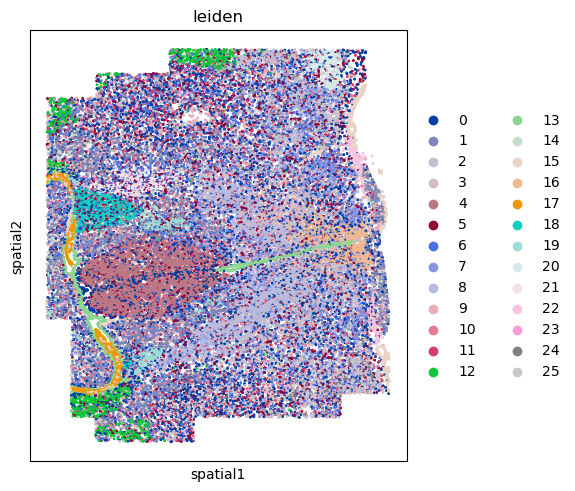

In [128]:
sq.pl.spatial_scatter(
    adata,
    shape=None,
    color=[
        "leiden",
    ],
    wspace=0.4,
)

In [129]:
gene_list  = adata.var_names.tolist()
annotation_dict = {
    "Endothelial": ["Flt1","Pecam1"],
    "Pericyte": ["Vtn"],
    "Fibroblast": ["Bnc2","Fbxl7"],
    "VLMC1": ["Dcn"],
    "VLMC2": ['Egfr','Tbx15','Rspo3','Slc26a7'],
    "Epithelial":["Kl","Ttr","Clic6"], # http://mousebrain.org/celltypes/CHOR.html
    "Ependymal":["Tmem212","Dnah6"],
    "Hypendymal":['Spp2','Sspo'], # http://mousebrain.org/celltypes/HYPEN.html
    "Microglia": ["Cx3cr1"],
    "Astrocyte": ["Aqp4","Clu","Cpe","Gfap","Gja1","Slc1a2","Slc1a3"],
    "Excitatory neuron, thalamus": ["Synpo2","Prkcd","Ramp3","Ptpn3","Shox2"], #http://mousebrain.org/celltypes/DEGLU1.html
    "Cholinergic neurons, habenula": ['Chat','Lrrc55','Tac2','Nwd2'],
    "Dopaminergic neuron, midbrain": ["Slc6a3","En1"], # http://mousebrain.org/celltypes/MBDOP2.html
    "GABAergic": ["Gad1","Gad2"],
    "OPC": ["Pdgfra"],
    "COP": ["C1ql1"],
    "MFOL": ["Mag","Mog"],
    "MOL": ["Plp1"],
    "Corticotrope": ["Crhr1","Tbx19"],
    "Gonadotrope": ["Cga","Fshb","Nr5a1"],
    "Lactotrope": ["Prl","Greb1","Agtr1a"],
    "Melanotrope": ["Oacyl","Pomc","Esm1"],
    "Tanycyte": ['Col23a1','Rax','Lhx2','Prdx6','Ptn'],
    "Pituitary_stem": ["Rbpms","Cyp2f2","Sox2","Aldh1a2"],
    "Somatotrope": ["Gh","Pappa2"],
    "Thyrotrope": ["Tshb","Dio2"],
    "Cycling": ["Top2a","Mki67"],
    "GABAergic Interneuron":["Gad1", "Gad2"],
    "Glutamatergic neuron": ["Slc17a6"],
    "Dopmanigergic neuron": ["Slc18a2", "Th"],
    "Cholinergic neruon":["Chat"],
    "Neuron": ["Mir124a-1hg","Snap25"]
}
filtered_markers = {
    key: [v for v in vals if v in gene_list]
    for key, vals in annotation_dict.items()
}
keys_to_remove = ["Pericyte", "Fibroblast", 
                  "VLMC2","Hypendymal",
                  "Excitatory neuron, thalamus","COP","Neuron"]
for k in keys_to_remove:
    filtered_markers.pop(k, None)   # safely remove if present

/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:179: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax

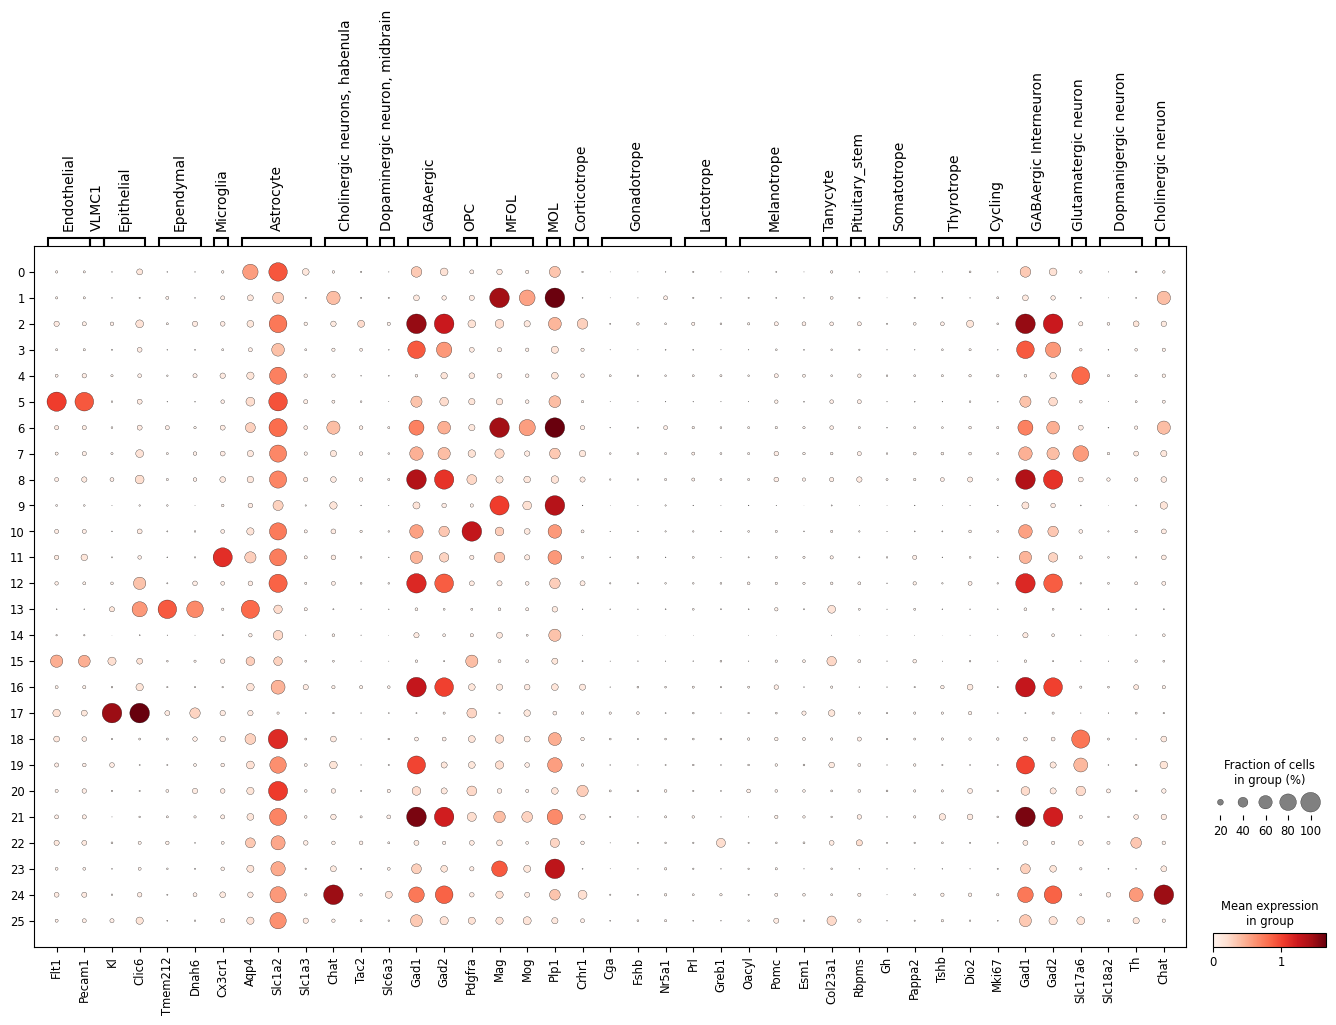

In [130]:
sc.pl.dotplot(adata, 
              filtered_markers, 
              'leiden', 
              mean_only_expressed = False, 
              log=True, 
             )

# Count based normalization

In [ ]:
adata = sc.read_h5ad('region_R2_adata_filt_scrublet.h5ad')

In [ ]:
from scipy import sparse
# normalize counts by volume
inv_volumes = 1 / adata.obs["volume"].values # scaling factor 
inv_vol_diag = sparse.diags(inv_volumes)
adata.layers["counts_volume_norm"] = inv_vol_diag @ adata.layers["counts"]

# scale
total_counts = np.array(adata.layers["counts_volume_norm"].sum(axis=1)).flatten()
scale_factor = 250 / np.mean(total_counts)

adata.layers["counts_volume_norm_scaled"] = adata.layers["counts_volume_norm"] * scale_factor

adata = adata[adata.obs["doublet_score"] <= 0.25].copy()


In [92]:
# from matplotlib.colors import ListedColormap
# import scanpy as sc
# import squidpy as sq

# # Get all unique leiden clusters
# clusters = adata.obs["leiden"].unique().astype(str)

# for cluster in clusters:
#     adata.obs["highlight"] = adata.obs["leiden"].astype(str).apply(
#         lambda x: "highlight" if x == cluster else "other"
#     )

#     custom_palette = ListedColormap(["red", "lightgrey"])

#     sq.pl.spatial_scatter(
#         adata,
#         shape=None,
#         color="highlight",
#         palette=custom_palette,
#         wspace=0.4,
#         alpha=0.3,
#         title=f"Cluster {cluster}",
#     )


In [93]:
# sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")


In [95]:
# sc.pl.rank_genes_groups_dotplot(
#     adata, groupby="leiden", standard_scale="var", n_genes=10
# )

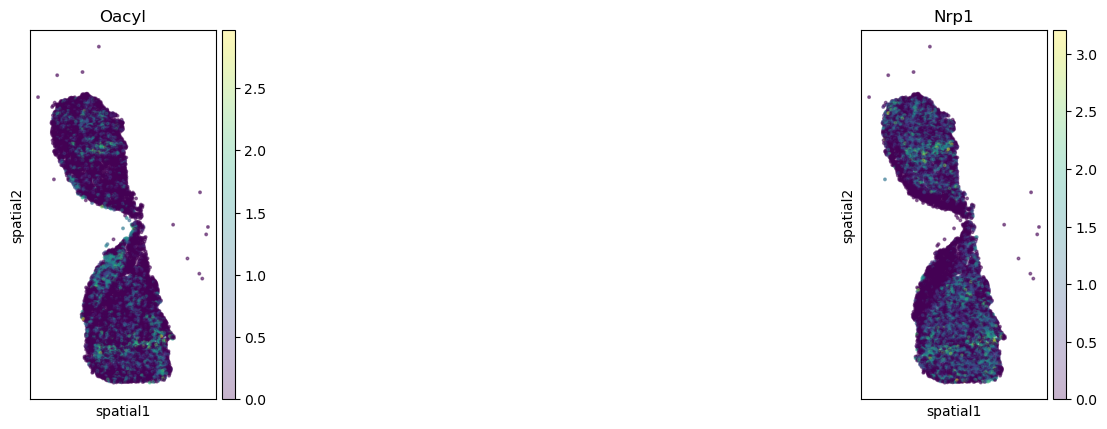

In [80]:
sq.pl.spatial_scatter(
    adata,
    shape=None,
    color=["Oacyl","Nrp1"],
    wspace=0.4,
    alpha=0.3,    
)

/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` par

[<Axes: ylabel='n_genes_by_counts'>, <Axes: ylabel='total_counts'>]

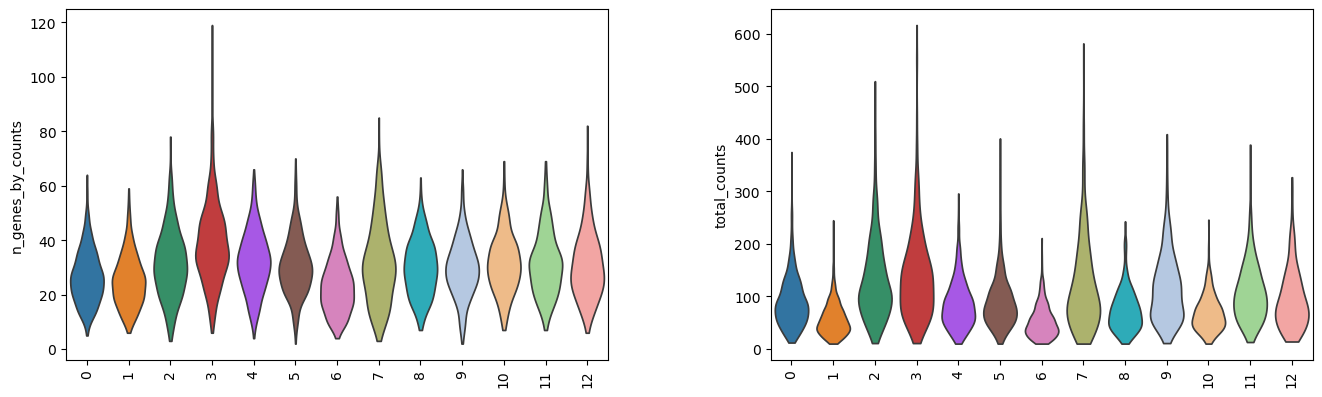

In [48]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts"],
    groupby='leiden',
    size=0,
    rotation = 90,
    multi_panel=True,
    show = False
)

In [97]:
gene_list  = adata.var_names.tolist()
annotation_dict = {
    "Endothelial": ["Flt1","Pecam1"],
    "Pericyte": ["Vtn"],
    "Fibroblast": ["Bnc2","Fbxl7"],
    "VLMC1": ["Dcn"],
    "VLMC2": ['Egfr','Tbx15','Rspo3','Slc26a7'],
    "Epithelial":["Kl","Ttr","Clic6"], # http://mousebrain.org/celltypes/CHOR.html
    "Ependymal":["Tmem212","Dnah6"],
    "Hypendymal":['Spp2','Sspo'], # http://mousebrain.org/celltypes/HYPEN.html
    "Microglia": ["Cx3cr1"],
    "Astrocyte": ["Aqp4","Clu","Cpe","Gfap","Gja1","Slc1a2","Slc1a3"],
    "Excitatory neuron, thalamus": ["Synpo2","Prkcd","Ramp3","Ptpn3","Shox2"], #http://mousebrain.org/celltypes/DEGLU1.html
    "Cholinergic neurons, habenula": ['Chat','Lrrc55','Tac2','Nwd2'],
    "Dopaminergic neuron, midbrain": ["Slc6a3","En1"], # http://mousebrain.org/celltypes/MBDOP2.html
    "GABAergic": ["Gad1","Gad2"],
    "OPC": ["Pdgfra"],
    "COP": ["C1ql1"],
    "MFOL": ["Mag","Mog"],
    "MOL": ["Plp1"],
    "Corticotrope": ["Crhr1","Tbx19"],
    "Gonadotrope": ["Cga","Fshb","Nr5a1"],
    "Lactotrope": ["Prl","Greb1","Agtr1a"],
    "Melanotrope": ["Oacyl","Pomc","Esm1"],
    "Tanycyte": ['Col23a1','Rax','Lhx2','Prdx6','Ptn'],
    "Pituitary_stem": ["Rbpms","Cyp2f2","Sox2","Aldh1a2"],
    "Somatotrope": ["Gh","Pappa2"],
    "Thyrotrope": ["Tshb","Dio2"],
    "Cycling": ["Top2a","Mki67"],
    "GABAergic Interneuron":["Gad1", "Gad2"],
    "Glutamatergic neuron": ["Slc17a6"],
    "Dopmanigergic neuron": ["Slc18a2", "Th"],
    "Cholinergic neruon":["Chat"],
    "Neuron": ["Mir124a-1hg","Snap25"]
}
filtered_markers = {
    key: [v for v in vals if v in gene_list]
    for key, vals in annotation_dict.items()
}
keys_to_remove = ["Pericyte", "Fibroblast", 
                  "VLMC2","Hypendymal",
                  "Excitatory neuron, thalamus","COP","Neuron"]
for k in keys_to_remove:
    filtered_markers.pop(k, None)   # safely remove if present

In [98]:
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)


/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:179: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax

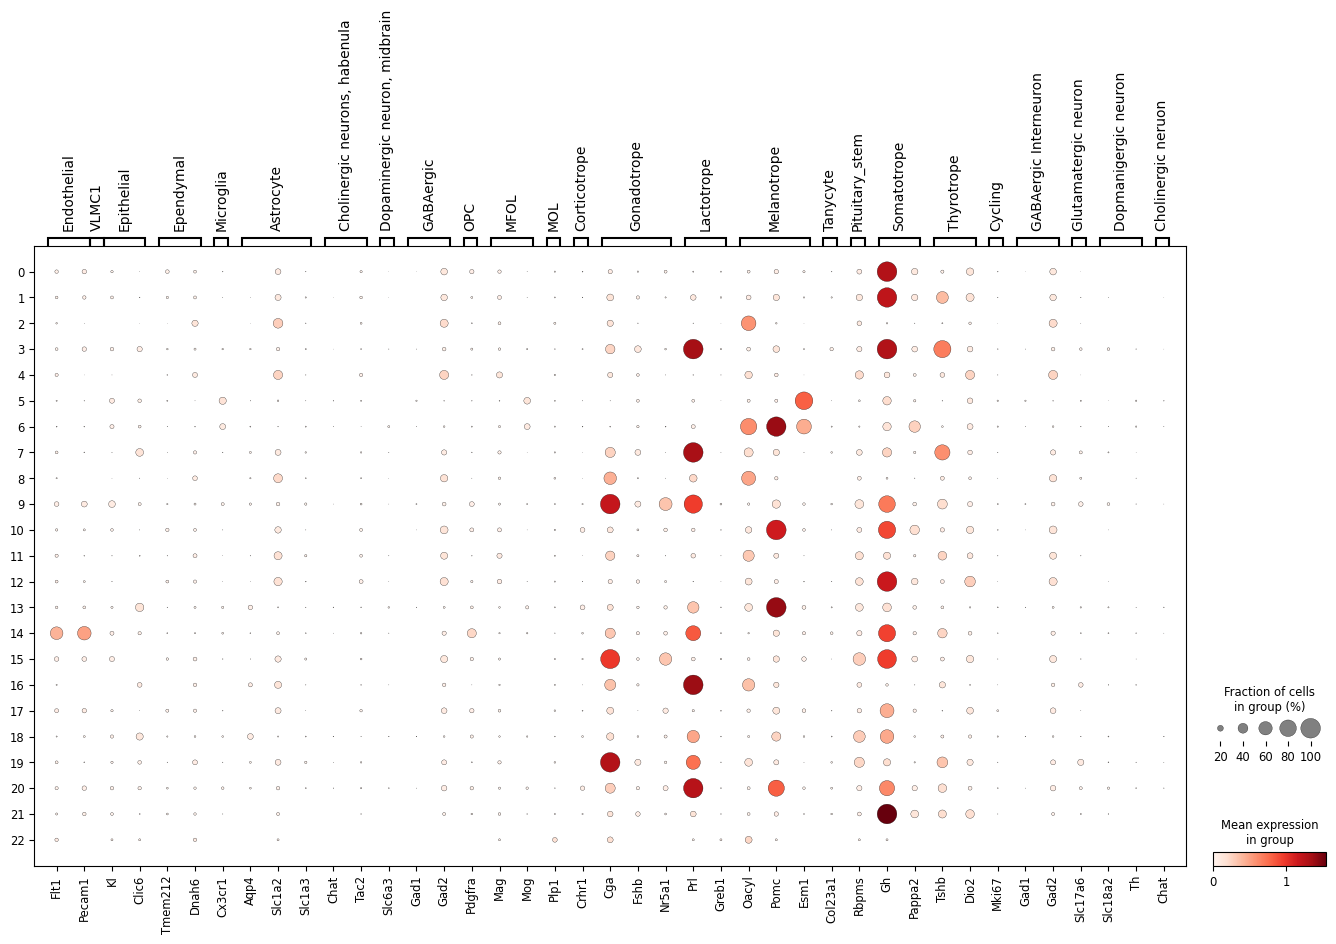

In [99]:
sc.pl.dotplot(adata, 
              filtered_markers, 
              'leiden', 
              mean_only_expressed = False, 
              log=True, 
             )

/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:179: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax

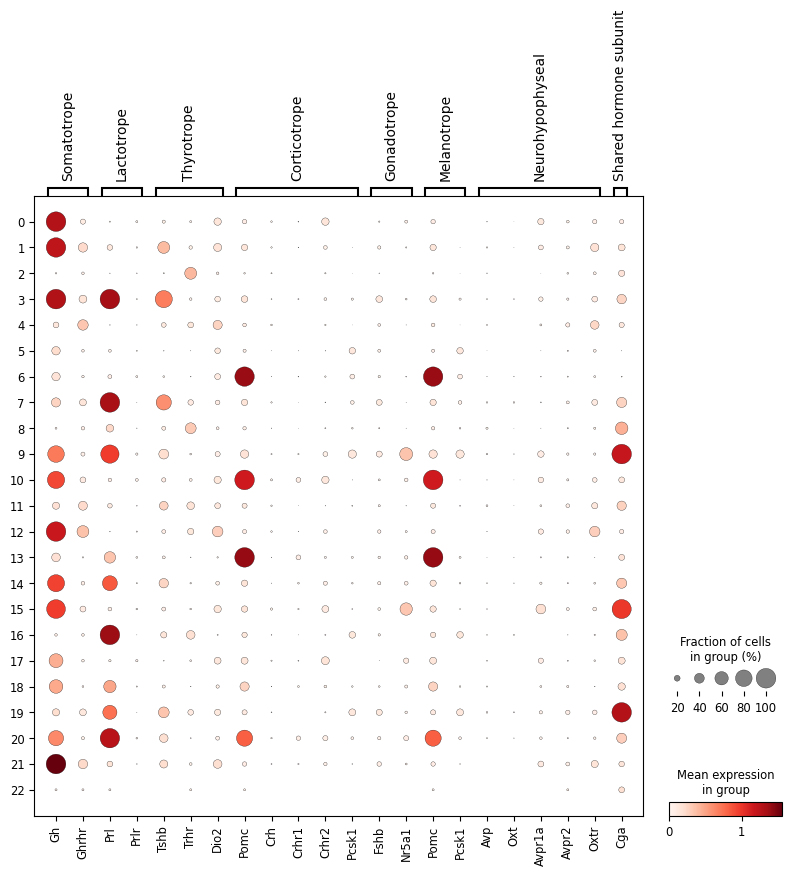

In [100]:
marker_dict = {
    "Somatotrope": ["Gh", "Ghrhr"],
    "Lactotrope": ["Prl", "Prlr"],
    "Thyrotrope": ["Tshb","Trhr","Dio2"],
    "Corticotrope": ["Pomc", "Crh", "Crhr1", "Crhr2", "Pcsk1"],
    "Gonadotrope": ["Fshb", "Nr5a1"],
    "Melanotrope": ["Pomc", "Pcsk1"],  # Pomc reused here as well
    "Neurohypophyseal": ["Avp", "Oxt", "Avpr1a", "Avpr2", "Oxtr"],
    "Shared hormone subunit": ["Cga"],

}


sc.pl.dotplot(adata, 
              marker_dict,
              'leiden', 
              mean_only_expressed = False, 
              log=True, 
             )

In [74]:
# Define your mapping
leiden_to_celltype = {
    '0': 'Somatotrope',
    '1': 'Melanotrope',
    '2': 'Lactosomatotrope',
    '3': 'Gonadotrope',
    '4': 'Lactotrope',
    '5': 'Somatotrope',
    '6': 'none',
    '7': 'Melanotrope', # yes
    '8': 'Melanotrope', # yes
    '9': 'Melanotrope', # yes
    '10': 'none',
    '11': 'mixed_markers',
    '12': 'Somatotrope',
    
}

# Add the annotation to your adata.obs
adata.obs['celltype'] = adata.obs['leiden'].map(leiden_to_celltype).astype('category')


/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/Users

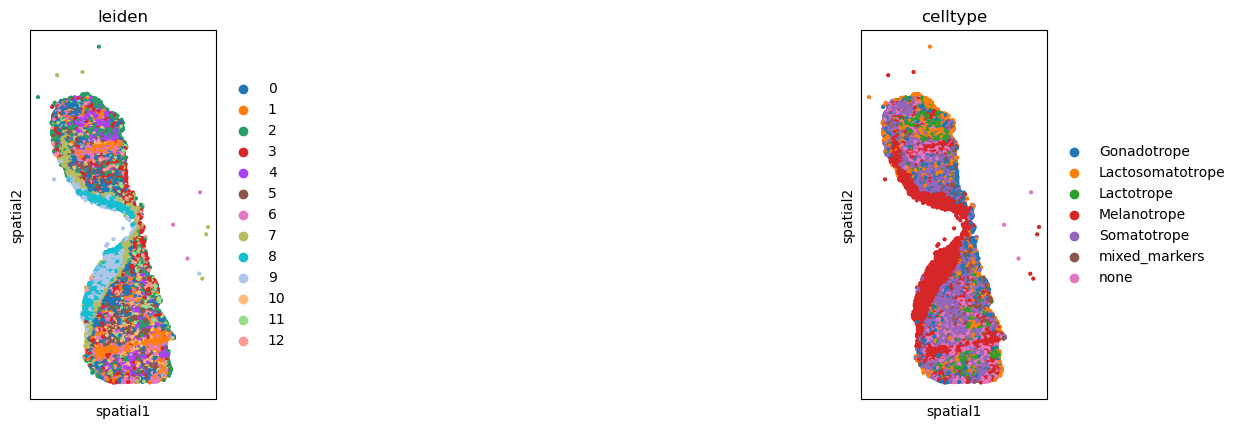

In [75]:
sq.pl.spatial_scatter(
    adata,
    shape=None,
    color=[
        "leiden","celltype",
    ],
    wspace=0.4,
)

In [76]:
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)


In [77]:
sq.gr.nhood_enrichment(adata, cluster_key="leiden")


  0%|                                                                                  | 0/1000 [00:00<?, ?/s]/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 93.75/s]


/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/squidpy/pl/_utils.py:556: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


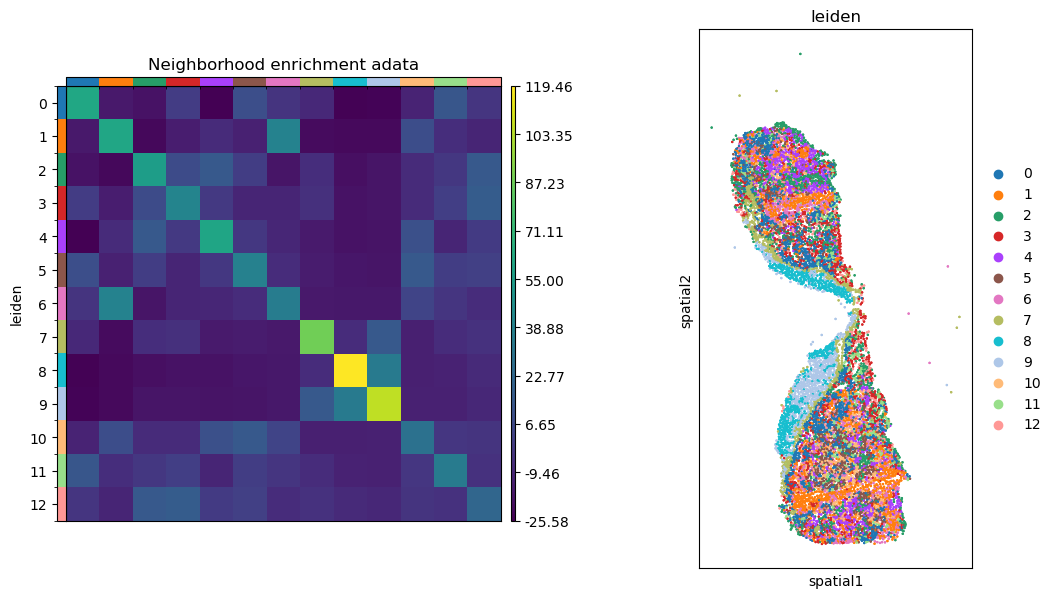

In [79]:
fig, ax = plt.subplots(1, 2, figsize=(13, 7))
sq.pl.nhood_enrichment(
    adata,
    cluster_key="leiden",
    figsize=(8, 8),
    title="Neighborhood enrichment adata",
    ax=ax[0],
)
sq.pl.spatial_scatter(adata, color="leiden", shape=None, size=2, ax=ax[1])

In [81]:
sq.gr.nhood_enrichment(adata, cluster_key="celltype")


  0%|                                                                                  | 0/1000 [00:00<?, ?/s]/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.38/s]


/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/squidpy/pl/_utils.py:556: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


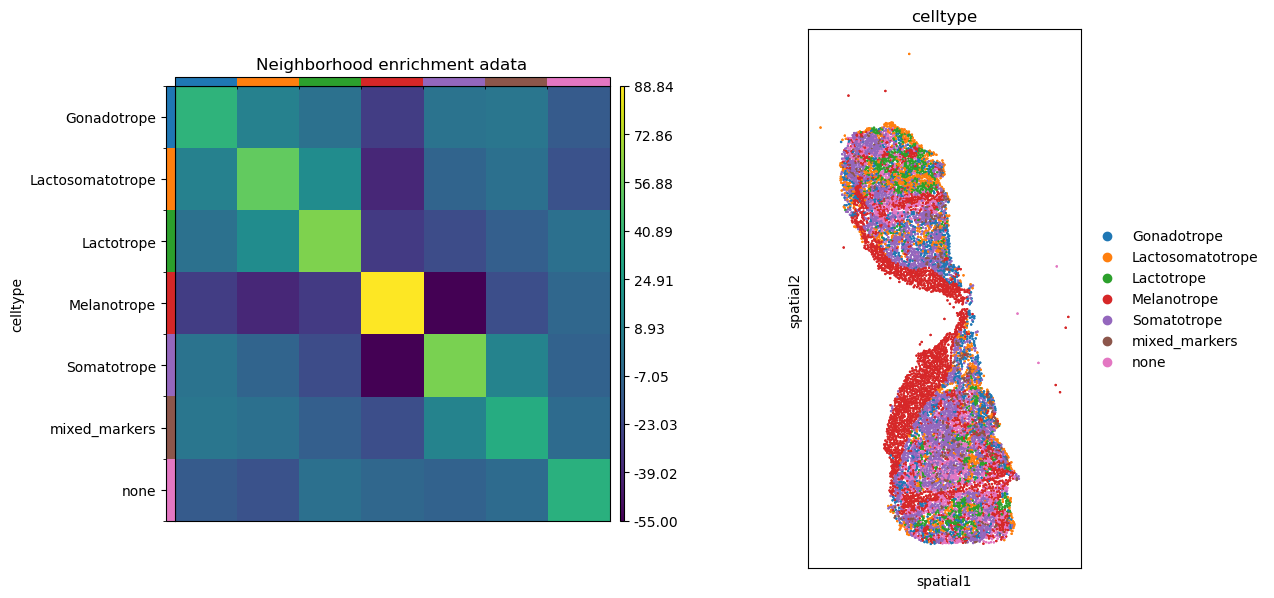

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(13, 7))
sq.pl.nhood_enrichment(
    adata,
    cluster_key="celltype",
    figsize=(8, 8),
    title="Neighborhood enrichment adata",
    ax=ax[0],
)
sq.pl.spatial_scatter(adata, color="celltype", shape=None, size=2, ax=ax[1])

In [37]:
# adata.write_h5ad('adata_r2_processed.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 40632 × 300
    obs: 'fov', 'volume', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass'
    uns: 'spatial'
    obsm: 'blank_genes', 'spatial'

In [6]:
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)


In [7]:
sq.gr.centrality_scores(adata, cluster_key="leiden")


KeyError: 'Cluster key `leiden` not found in `adata.obs`.'

In [20]:
# File paths
meta_path = "pilot_data/region_R2/cell_metadata.csv"
expr_path = "pilot_data/region_R2/cell_by_gene.csv"

# Load data
obs = pd.read_csv(meta_path, index_col=0)
X = pd.read_csv(expr_path, index_col=0)

obs.index.name = None
X.index.name = None


In [26]:
obs.index

Index([2362950300001100014, 2362950300001100029, 2362950300001100030,
       2362950300001100031, 2362950300001100033, 2362950300001100034,
       2362950300001100035, 2362950300001100036, 2362950300001100037,
       2362950300001100039,
       ...
       2362950300070100257, 2362950300070100259, 2362950300070100261,
       2362950300070100262, 2362950300070100263, 2362950300070100264,
       2362950300070100266, 2362950300070200011, 2362950300070200093,
       2362950300070200130],
      dtype='int64', length=40632)

In [27]:
X.index

Index([2362950300001100014, 2362950300001100029, 2362950300001100030,
       2362950300001100031, 2362950300001100033, 2362950300001100034,
       2362950300001100035, 2362950300001100036, 2362950300001100037,
       2362950300001100039,
       ...
       2362950300070100257, 2362950300070100259, 2362950300070100261,
       2362950300070100262, 2362950300070100263, 2362950300070100264,
       2362950300070100266, 2362950300070200011, 2362950300070200093,
       2362950300070200130],
      dtype='int64', length=40632)

In [21]:
# Ensure indices match
assert all(obs.index == X.index), "Mismatch between metadata and expression matrix rows"


In [34]:
# Create AnnData object
ad_viz = AnnData(X=X.values, obs=obs)

ad_viz.var_names = X.columns
ad_viz.var["gene_symbol"] = X.columns


/Users/liz/miniconda3/envs/merscope/lib/python3.11/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [35]:
# filter out blanks before clusering
keep_genes = [x for x in ad_viz.var.index.tolist() if 'Blank' not in x]
ad_viz = ad_viz[:, keep_genes]

# copy to cell_by_gene_matrix
cell_by_gene = deepcopy(ad_viz.to_df())

ad_viz

View of AnnData object with n_obs × n_vars = 40632 × 300
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass'
    var: 'gene_symbol'

### Filter Cells Based on Minimum Gene Expression Counts

<Axes: >

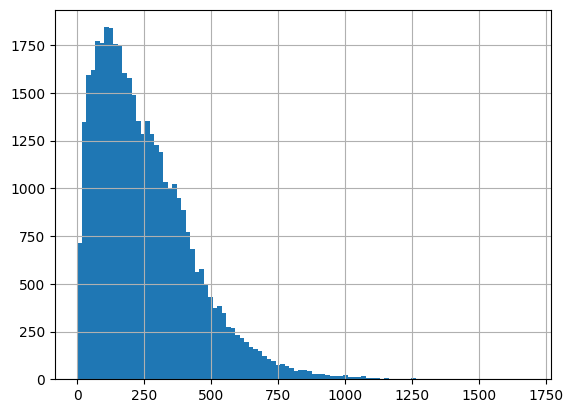

In [36]:
# before filtering
ser_exp = ad_viz.to_df().sum(axis=1)
ser_exp.hist(bins=100)


In [39]:
import numpy as np
import matplotlib.pyplot as plt

def plot_knee_curve(adata):
    """
    Plot a single knee curve (UMI counts per barcode) for the entire dataset.
    """
    umi_counts = np.array(adata.X.sum(axis=1)).flatten()
    umi_counts.sort()
    umi_counts = umi_counts[::-1]  # descending

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.loglog(range(1, len(umi_counts) + 1), umi_counts, linewidth=2, color="black")

    ax.set_xlabel("Barcodes", fontsize=14)
    ax.set_ylabel("UMI Counts", fontsize=14)
    ax.axhline(y=500, linewidth=1.5, color="#505050", linestyle='--', label='500 UMI')
    ax.axhline(y=200, linewidth=1.5, color="#A0A0A0", linestyle='--', label='200 UMI')

    ax.legend(fontsize=12)
    ax.grid(True, which="both", linestyle=':', linewidth=0.5)
    ax.set_title("Knee Plot", fontsize=16)
    plt.tight_layout()
    plt.show()


In [37]:
min_expression = 25
keep_cells = ser_exp[ser_exp > min_expression].index.tolist()
ad_viz = ad_viz[keep_cells]
ad_viz


View of AnnData object with n_obs × n_vars = 39292 × 300
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass'
    var: 'gene_symbol'

<Axes: >

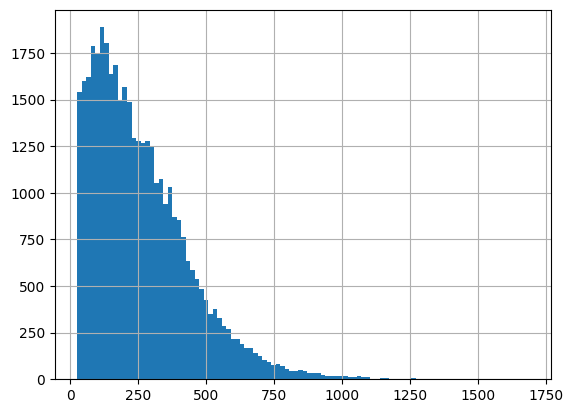

In [38]:
ser_exp = ad_viz.to_df().sum(axis=1)
ser_exp.hist(bins=100)


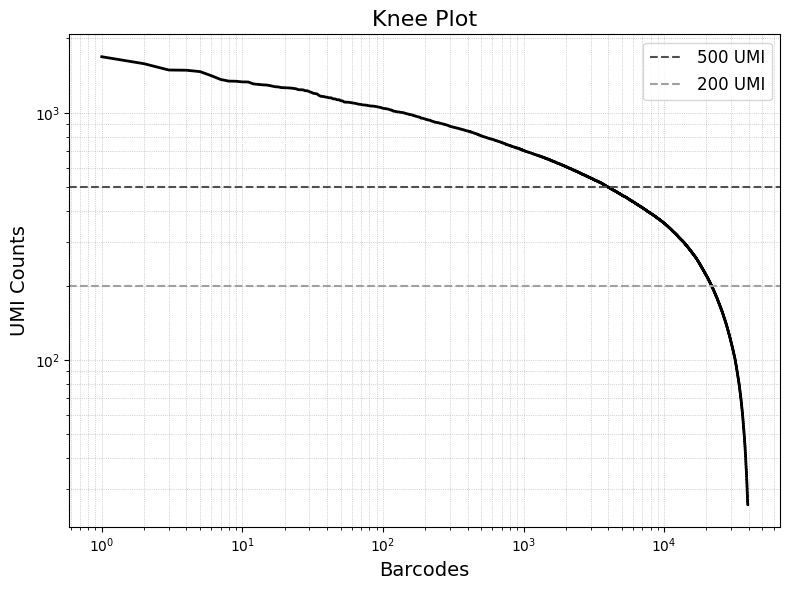

In [42]:
plot_knee_curve(ad_viz)


### Filter Cells Based on Volume

<Axes: >

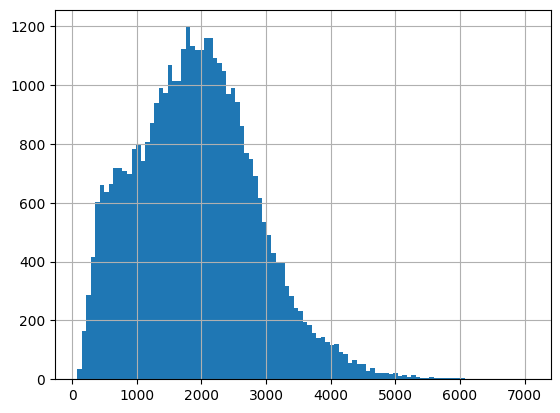

In [43]:
ser_volume = ad_viz.obs['volume']
ser_volume.hist(bins=100)

In [ ]:
# # filter cells based on volume
# min_volume = 50
# keep_cells = ser_volume[ser_volume > min_volume].index.tolist()
# ad_viz = ad_viz[keep_cells]
# ad_viz

In [ ]:
# ser_volume = ad_viz.obs['volume']
# ser_volume.hist(bins=100)

# UMAP and Single-Cell Clustering

In [ ]:
resolution = 1.5

# Leiden Clustering
######################

# dividing by volume instead
sc.pp.normalize_total(ad_viz)
sc.pp.log1p(ad_viz)
sc.pp.scale(ad_viz, max_value=10)
sc.tl.pca(ad_viz, svd_solver='arpack')
sc.pp.neighbors(ad_viz, n_neighbors=10, n_pcs=20)
sc.tl.umap(ad_viz)
sc.tl.leiden(ad_viz, resolution=resolution)

# Calculate Leiden Signatures
#########################################df_pos.index = [str(x) for x in list(range(df_pos.shape[0]))]
ser_counts = ad_viz.obs['leiden'].value_counts()
ser_counts.name = 'cell counts'
meta_leiden = pd.DataFrame(ser_counts)

cat_name = 'leiden'
sig_leiden = pd.DataFrame(columns=ad_viz.var_names, index=ad_viz.obs[cat_name].cat.categories)
for clust in ad_viz.obs[cat_name].cat.categories:
    sig_leiden.loc[clust] = ad_viz[ad_viz.obs[cat_name].isin([clust]),:].X.mean(0)
sig_leiden = sig_leiden.transpose()
leiden_clusters = ['Leiden-' + str(x) for x in sig_leiden.columns.tolist()]
sig_leiden.columns = leiden_clusters
meta_leiden.index = sig_leiden.columns.tolist()
meta_leiden['leiden'] = pd.Series(meta_leiden.index.tolist(), index=meta_leiden.index.tolist())

# generate colors for categories by plotting
sc.pl.umap(ad_viz, color="leiden", legend_loc='on data')
cats = ad_viz.obs['leiden'].cat.categories.tolist()
colors = list(ad_viz.uns['leiden_colors'])
cat_colors = dict(zip(cats, colors))

# colors for clustergrammer2
ser_color = pd.Series(cat_colors)
ser_color.name = 'color'
df_colors = pd.DataFrame(ser_color)
df_colors.index = ['Leiden-' + str(x) for x in df_colors.index.tolist()]

df_colors.loc[''] = 'white'

# Save AnnData
After saving the anndata, use the Files tab to download the `.hdf5` to your local computer. This file can then be loaded into the MERSCOPE Vizualizer where the `leiden` clusters and UMAP dimensionality reduction embedding can be imported.

In [ ]:
ad_viz

In [ ]:
clustered_filename = anndata_filename.split('.hdf5')[0] + '_clustered.hdf5'
ad_viz.write_h5ad(clustered_filename)